# Preprocessing the data

In [2]:
import LoadUtils
import pandas as pd

PATH_BUSINESS = 'yelp_dataset/yelp_academic_dataset_business.json'
PATH_REVIEW = 'yelp_dataset/yelp_academic_dataset_review.json'

In [3]:
# Recommend to set to a low value like 100,000 for quicker iteration.
# Set to -1 to load the full files, which will make processing SIGNIFICANTLY slower.
N_LINES = 4_000_000

In [4]:
# Filter for OPEN ONLY businesses in California
data_business = LoadUtils.load_matches(PATH_BUSINESS, n_lines=N_LINES, verbose=True,
                                       func=LoadUtils.fn_all,
                                       args=[(LoadUtils.fn_eq, "state", "CA"),
                                             (LoadUtils.fn_eq, "is_open", 1)])
business_ca_open = pd.DataFrame(data_business)

# Display filtered data
print(f"Number of open businesses in California: {business_ca_open.shape[0]}")
print(business_ca_open.head())

Now loading yelp_dataset/yelp_academic_dataset_business.json
[=] Loaded 4065/150345 entries (0 unprocessable)
Number of open businesses in California: 4065
              business_id                             name  \
0  noByYNtDLQAra9ccqxdfDw                              H&M   
1  IDtLPgUrqorrpqSLdfMhZQ             Helena Avenue Bakery   
2  nUqrF-h9S7myCcvNDecOvw             Iron Horse Auto Body   
3  bYjnX_J1bHZob10DoSFkqQ      Tinkle Belle Diaper Service   
4  SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company   

                 address           city state postal_code   latitude  \
0       827-833 State St  Santa Barbara    CA       93101  34.420209   
1  131 Anacapa St, Ste C  Santa Barbara    CA       93101  34.414445   
2         825 Cacique St  Santa Barbara    CA       93103  34.419620   
3                         Santa Barbara    CA       93101  34.420334   
4      230 Stearns Wharf  Santa Barbara    CA       93101  34.408715   

    longitude  stars  review_count  is

In [5]:
biz_ids = set()
for item in data_business:
    biz_ids.add(item["business_id"])

# full data is 7 million entries, so this takes pretty long (around 3 minutes)
data_review = LoadUtils.load_matches(PATH_REVIEW, n_lines=N_LINES, verbose=True,
                                     func=LoadUtils.fn_in,
                                     args=("business_id", biz_ids))

Now loading yelp_dataset/yelp_academic_dataset_review.json
[====================] Loaded 156605/4000000 entries (0 unprocessable)


In [6]:
df_review = pd.DataFrame(data_review)
review_ca_open = df_review.drop(labels=['stars', 'useful', 'funny', 'cool', 'date'], axis=1)

# Display filtered reviews
print(f"{len(set(review_ca_open['user_id']))} users" + \
      f" made {len(set(review_ca_open['review_id']))} reviews" + \
      f" across {len(set(review_ca_open['business_id']))} businesses")
print(review_ca_open.head())

89287 users made 156605 reviews across 2401 businesses
                review_id                 user_id             business_id  \
0  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
1  pUycOfUwM8vqX7KjRRhUEA  59MxRhNVhU9MYndMkz0wtw  gebiRewfieSdtt17PTW6Zg   
2  eCiWBf1CJ0Zdv1uVarEhhw  OhECKhQEexFypOMY6kypRw  vC2qm1y3Au5czBtbhc-DNw   
3  YbMyvlDA2W3Py5lTz8VK-A  4hBhtCSgoxkrFgHa4YAD-w  bbEXAEFr4RYHLlZ-HFssTA   
4  L0jv8c2FbpWSlfNC6bbUEA  bFPdtzu11Oi0f92EAcjqmg  IDtLPgUrqorrpqSLdfMhZQ   

                                                text  
0  This easter instead of going to Lopez Lake we ...  
1  Had a party of 6 here for hibachi. Our waitres...  
2  Yes, this is the only sushi place in town. How...  
3  Great burgers,fries and salad!  Burgers have a...  
4  What a great addition to the Funk Zone!  Grab ...  


In [7]:
# this cell takes pretty long on larger data, 4-5 minutes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Convert the textual reviews into a numerical representation using TF-IDF (Term Frequency-Inverse Document Frequency)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to 5000 most important terms
review_tfidf = tfidf.fit_transform(review_ca_open['text'])

print(f"TF-IDF Matrix Shape: {review_tfidf.shape}")  # High-dimensional representation

# Apply Dimentionality Reduction using Principal Component Analysis (PCA)
pca = PCA(n_components=50)  # Reduce to 50 components
reduced_reviews = pca.fit_transform(review_tfidf.toarray())

print(f"Reduced Dimensions Shape: {reduced_reviews.shape}")  # Lower-dimensional representation

TF-IDF Matrix Shape: (156605, 5000)
Reduced Dimensions Shape: (156605, 50)


# Clustering

Now clustering with k= 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30...

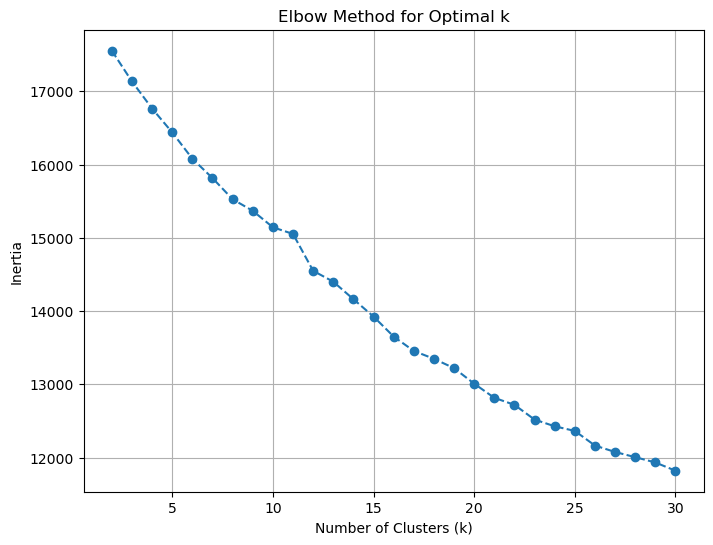

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the best number of clusters using Elbow Method
inertia = []
k_values = range(2, 30+1)

print("Now clustering with k=", end='')
for k in k_values:
    print(f" {k}...", end='')
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_reviews)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [10]:
# Apply K-Means with the chosen number of clusters based on the Elbow Curve
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_reviews)

clustered_reviews = review_ca_open[['review_id', 'user_id', 'business_id']]
clustered_reviews = clustered_reviews.assign(cluster=pd.Series(clusters))
print(clustered_reviews.head())

                review_id                 user_id             business_id  \
0  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
1  pUycOfUwM8vqX7KjRRhUEA  59MxRhNVhU9MYndMkz0wtw  gebiRewfieSdtt17PTW6Zg   
2  eCiWBf1CJ0Zdv1uVarEhhw  OhECKhQEexFypOMY6kypRw  vC2qm1y3Au5czBtbhc-DNw   
3  YbMyvlDA2W3Py5lTz8VK-A  4hBhtCSgoxkrFgHa4YAD-w  bbEXAEFr4RYHLlZ-HFssTA   
4  L0jv8c2FbpWSlfNC6bbUEA  bFPdtzu11Oi0f92EAcjqmg  IDtLPgUrqorrpqSLdfMhZQ   

   cluster  
0        6  
1        4  
2       13  
3        0  
4        8  


In [11]:
def get_cluster_of(k):
    """
    Given a df column name, make a new df that associates the named
    attribute to the cluster that it most commonly belongs to.
    """
    output = clustered_reviews.groupby(
        [k, 'cluster']).size().reset_index(name='occurrence')
    output = output.loc[
        output.groupby(k)['occurrence'].idxmax()
    ]
    return output.drop('occurrence', axis=1)

In [12]:
biz_cluster = get_cluster_of('business_id')
user_cluster = get_cluster_of('user_id')

# Output

In [14]:
def recommend_businesses(user_id, num_recommendations=5):
    # Get the cluster that the user belongs to
    c = user_cluster[user_cluster['user_id'] == user_id]['cluster'].values[0]
    
    # Get all businesses in this cluster
    businesses = biz_cluster[biz_cluster['cluster'] == c]
    
    # Exclude businesses the user has already reviewed
    reviewed_businesses = clustered_reviews[clustered_reviews['user_id'] == user_id]['business_id'].unique()
    recommendations = businesses[~businesses['business_id'].isin(reviewed_businesses)]

    # Select top businesses for recommendation (or fewer if less available)
    recommendations = recommendations.sample(n=min(num_recommendations, len(recommendations)))
    recommendations = recommendations.merge(business_ca_open[['business_id', 'name', 'categories']], on='business_id')
    return recommendations[['name', 'categories']]

In [15]:
uid = user_cluster.iloc[999]['user_id']

recs = recommend_businesses(uid)
print(f"For user with id {uid}, these are the recommendations:")
print(recs)

For user with id -ip_e0pCYjbE6ljyEIDHJg, these are the recommendations:
                         name  \
0             Jack in the Box   
1  U-Haul Neighborhood Dealer   
2                   Carl's Jr   
3                    Rite Aid   
4                        IHOP   

                                          categories  
0  Restaurants, Fast Food, Tacos, Breakfast & Bru...  
1  Self Storage, Packing Supplies, Local Services...  
2                    Burgers, Restaurants, Fast Food  
3     Shopping, Food, Drugstores, Convenience Stores  
4  American (Traditional), Breakfast & Brunch, Re...  


In [16]:
# Find insights for users and business owners using Association Rules
from mlxtend.frequent_patterns import apriori, association_rules

# Prepare data for Apriori (one-hot encoding)
user_cluster_matrix = clustered_reviews.sort_values('user_id').pivot_table(
    index='user_id', columns='cluster', aggfunc='size', fill_value=0
)
user_cluster_matrix = user_cluster_matrix.applymap(lambda x: x > 0)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(user_cluster_matrix, min_support=0.03, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, user_cluster_matrix, metric="lift", min_threshold=0.1)

# Sort rules by lift and display
rules_sorted = rules.sort_values(by="lift", ascending=False)
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

  antecedents consequents   support  confidence      lift
5         (6)         (4)  0.040151    0.115701  0.789560
4         (4)         (6)  0.040151    0.273999  0.789560
2         (3)         (6)  0.051687    0.253725  0.731138
3         (6)         (3)  0.051687    0.148943  0.731138
0         (1)         (6)  0.040431    0.236814  0.682409
